# Resistance breakout strategy

# how the strategy works:
We believe that a strong increase in volatility leads to a breakout of the level. 

If such a condition occurs, set the stop loss using the ATR. 

For simplicity, the transaction fee is assumed to be 0

We use time between 09:35 and 16:00 as regular trading hours

We use 1 minute trading bars

<ol>
 <li>Average True Range (ATR) - we need this for calculating the stop loss</li>
 <li>Cumulative Annual Growth Rate (CAGR) for comparison of the strategy at different stock</li>
</ol>

Additional materials used: 
https://www.udemy.com/course/algorithmic-trading-quantitative-analysis-using-python/
ATR https://www.youtube.com/watch?v=IuhLfRJTHmY

In [1]:
import numpy as np
import pandas as pd
# alpha_vantage is library for getting some more stock
from alpha_vantage.timeseries import TimeSeries
import copy
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
#     Because trading session between 09:35 and 16:00 has 390 minute time bars
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

# Let's take some more stocks, which can be compared to

In [2]:
tickers = ["AAPL","MSFT", "SPY"]
# you can get your own API key here: https://www.alphavantage.co/
ts = TimeSeries(key='MRA63QBLDA8JNZJW', output_format='pandas')

ohlc_intraday = {} # directory with ohlc value for each stock   

for ticker in tickers:
    data = ts.get_intraday(symbol=ticker,interval='5min', outputsize='full')[0]

    data.columns = ["Open","High","Low","Close","Volume"]
#     because we get data reversing order from alpha_vantage
    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00') #remove data outside regular trading hours
    ohlc_intraday[ticker] = data

In [3]:
euros = pd.read_csv('eurostoxx_data.csv', index_col='DateTime')
euros.index = pd.to_datetime(euros.index)
euros = euros.between_time('09:35', '16:00')


conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last', 'Volume' : 'sum'}
euros = euros.resample('5min').agg(conversion)
# because resample automatically adds days off filled with NaN
euros.dropna(inplace=True)

ohlc_intraday["EUROS"] = euros

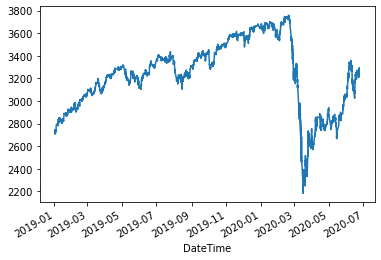

In [4]:
euros['Close'].plot()

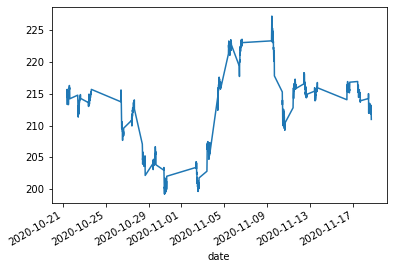

In [5]:
ohlc_intraday["MSFT"]['Close'].plot()

In [6]:
tickers = ohlc_intraday.keys()

In [7]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]

# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
#         if we have no signal  - do nothing and our return is 0
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
#            criteria of breakout up - if current high is bigger or equal than 20 bars before and current volume is much more than previous candle volume 
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:        
                tickers_signal[ticker] = "Buy" # if both criteria is true than we make signal as "Buy"
            
            
#            first criteria of breakout down - if current low is lower or equal than 20 bars before and current volume is much lover than previous candle volume             
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell" # if both criteria is true than we make signal as "Sell"
        
        elif tickers_signal[ticker] == "Buy":
#             making stop loss signal
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
#                 Making stop loss signal in the same way as "Buy" loss signal
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  SPY
calculating ATR and rolling max price for  EUROS
calculating returns for  AAPL
calculating returns for  MSFT
calculating returns for  SPY
calculating returns for  EUROS


Return  Sharpe Ratio  Max Drawdown
AAPL   0.947133      5.742255      0.022745
MSFT   1.732491     12.299909      0.017068
SPY    0.092056      1.109561      0.013690
EUROS  0.126014      1.501671      0.032217

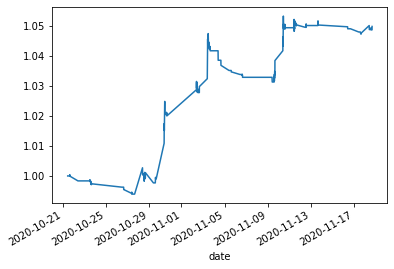

In [8]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
#     Cause of different time range we calculate "EUROS" separatly
    if ticker == 'EUROS': continue
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)



# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot()

#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers :
      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

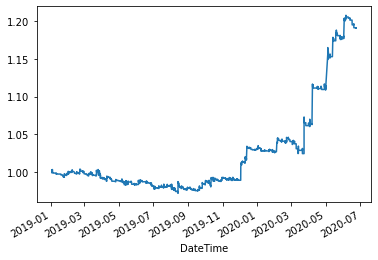

In [9]:
(1+ohlc_dict['EUROS']["ret"]).cumprod().plot()

# Things to improve:

<ol>
 <li>Overnight positions is allowed, which introduces a significant risk to the strategy</li>
 <li>Strategy involves high volatile stocks, this requires an additional stock search</li>
 <li>Addition test on different time intervals required</li>
 <li>Addition test on different stocks required</li>
 <li>Need add a fee to each transaction</li>
</ol>


# Conclusion
For further validation i can use stocks of different volatility,different sectors.

The main problem in the strategy is determining the breakout signal. To do this, you can use semantic signals for greater confidence in breaking through the level (but then  will have to change the trading interval to a longer one). 

You can also conduct a study of the impact of volume on the breakdown of the level - does this strategy really have a strict scientific basis? 
With more time I would make a machine learning model that predicts the level breakdown and compare its result with the current strategy.